<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 3: Web APIs & NLP
### Reddit Scams: Are We Vulnerable?
---

# 5.1 Modeling

In [13]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# model libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# display settings
pd.set_option('display.width', 10000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [14]:
# import tokenized datafrrame
rksc_df = pd.read_csv('../data/rk_sc_final.csv')

# re-label columns
cols = ['labels', 'features']

rksc_df = rksc_df.rename(columns={'label': 'labels',
                                  'removed_customised_stopwords_stems_str': 'features'})

print(rksc_df.head()) # inspect first 5 rows of df


   labels                                           features
0       0                               today birthday excit
1       0  normal thing today turn 24 havent celebr birth...
2       0  amaz proud sometim life surviv part birthday b...
3       0                                   made smile thank
4       0                                               love


In [15]:
# perform another preliminary check for shape and null values
print(rksc_df.isna().sum()) # it seems that there are null values even after dropping null during pre-processing
print(rksc_df.shape) 

labels        0
features    192
dtype: int64
(27335, 2)


In [16]:
# inspection of rows with null values

null_values = rksc_df[rksc_df['features'].isnull()]
null_values_index = null_values.index

# print(rksc_df.iloc[55]) # inspect first row
# print(rksc_df.iloc[274]) # inspect second row

# Get percentage of rows with null value
perc_null = len(null_values) / len(rksc_df) * 100

print('Percentage of rows with null values: ', round(perc_null,2),'%')

Percentage of rows with null values:  0.7 %


As the null value is less than 0.7% of the dataframe, we will proceed to drop all rows with null values.

In [17]:
# Due to some unexpected behaviour, there were 192 null values introduced during the import of the csv
# We will proceed to drop all rows with null values

rksc_df = rksc_df.dropna()

# Display Output
print(rksc_df.isna().sum())

labels      0
features    0
dtype: int64


Split the dataframe into X and y variables as we prepare for data modeling with Pipeline and GridSearchCV

In [18]:
# split into features and labels
X = rksc_df['features']
y = rksc_df['labels']

print(y.value_counts(normalize=True)) # To check for class imbalance

labels
0    0.50245
1    0.49755
Name: proportion, dtype: float64


Classes are considered balanced with marginal differences between labels.

In [19]:
# Split the features and labels into training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### 5.1.1 Obtaining the Baseline Scores

For the purpose of this project, we will consider two models: Naive Bayes (Multinomial) and Logistic Regression.
- **Multinomial Naive Bayes** 
    - It works based on the concept of probability and independence. 
    - It analyses the words and calculates the probability of the word being 1 or 0 independently. 
    - These individual probabilities are then combined to determine the overall probability.
- **Logistic Regression** 
    - It works based on using coefficients to give the words a form of weighting. 
    - It is easily interpretable and provides valuable insights into which words hold the most weight.
    - Since both models are computationally efficient with handling large datasets, they make good options for our project.

#### 5.1.2 Obtain the Cross-Validation Score for the 2 models using CountVectorizer

In [20]:
# Count Vectorizer for MultinomialNB and Logistic Regression

# CountVectorizer -> MultinomialNB, Setting up a Pipeline
pipe_count_base_nb = Pipeline([
    ('cvec', CountVectorizer()), # Vectorizer of choice
    ('nb', MultinomialNB()) # Estimation of choice
])

# CountVectorizer - > Logistic Regression, Setting up a Pipeline
pipe_count_base_logreg = Pipeline([
    ('cvec', CountVectorizer()), # Vectorizer of choice
    ('nb', LogisticRegression()) # Estimation of choice
])


# Calculate the cross validation score
pipe_count_base_nb_cv = cross_val_score(pipe_count_base_nb, X, y, cv = 5).mean()
pipe_count_base_logreg_cv = cross_val_score(pipe_count_base_logreg, X, y, cv = 5).mean()


print(f'''
Cross-validation Score for Base CountVectorizer MultinomialNB: {pipe_count_base_nb_cv}
Cross-validation Score for Base CountVectorizer Logistic Regression: {pipe_count_base_logreg_cv}


      ''')



Cross-validation Score for Base CountVectorizer MultinomialNB: 0.9720368913201612
Cross-validation Score for Base CountVectorizer Logistic Regression: 0.9583685380227612


      


#### 5.1.3 Obtain the Cross-Validation Score for the 2 models using TF-IDF

In [21]:
# TF-IDF for MultinomialNB and Logistic Regression

# TF-IDF -> MultinomialNB, Setting up a Pipeline
pipe_tfidf_base_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# TF-IDF -> LogisticRegression, Setting up a Pipeline
pipe_tfidf_base_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()), # Vectorizer of choice
    ('logreg', LogisticRegression()) # Estimation of choice
])



# Calculate the cross validation score
pipe_tfidf_base_nb_cv = cross_val_score(pipe_tfidf_base_nb, X, y, cv = 5).mean()
pipe_tfidf_base_logreg_cv = cross_val_score(pipe_tfidf_base_logreg, X, y, cv =5).mean()


# Print the scores from the various pipes
print(f'''
Cross-validation Score for Base TF-IDF MultinomialNB: {pipe_tfidf_base_nb_cv}
Cross-validation Score for Base TF-IDF Logistic Regression: {pipe_tfidf_base_logreg_cv}


      ''')


Cross-validation Score for Base TF-IDF MultinomialNB: 0.9725526129293092
Cross-validation Score for Base TF-IDF Logistic Regression: 0.9561576025365565


      


#### 5.1.5 Summary of Cross-Validation Score from the Vectorizers and Classifiers

In [34]:
# Compiling baseline accuracy scores into a dataframe

baseline_cv_scores = {
    'Model': ['MultinomialNB', 'Logistic Regression', 'MultinomialNB', 'Logistic Regression'],
    'Vectorization': ['CountVectorizer', 'CountVectorizer', 'TF-IDF', 'TF-IDF'],
    'CV Score': [pipe_count_base_nb_cv, pipe_count_base_logreg_cv, pipe_tfidf_base_nb_cv, 
                 pipe_tfidf_base_logreg_cv]  
}

# Convert dictionary to DataFrame
df_cv_scores = pd.DataFrame(baseline_cv_scores)

# Display the DataFrame
df_cv_scores

,Model,Vectorization,CV Score
0,MultinomialNB,CountVectorizer,0.972037
1,Logistic Regression,CountVectorizer,0.958369
2,MultinomialNB,TF-IDF,0.972553
3,Logistic Regression,TF-IDF,0.956158


**Analysis**

- From the table, we note that the highest cross-validation score occurs in Multinomial Naive Bayes with TF-IDF, with a score of 0.973. 
- All models performed well in their baseline cross-validation scores. 
- We will pick the top 2 highest scoring model-vectorizer pair to hypertune with GridSearchCV.

## 5.2 Multinomial Naive Bayes Model


### 5.2.1 TF-IDF Multinomial Naive Bayes Hyper-tuning

We would set the parameter grid for GridSearchCV() in a way that would cover most of the concerns we had for our data.

- `tfidf__analyzer `: Stemming causes some words to be chopped up and could lead to the words becoming prefix or suffix, while `char_wb` avoids creating n-gram that spread across words, rendering it meaningless. While `word` and `char` would be our default hyperparameters to analyze the data at a text level

- `tfidf__min_df`: Specify varying levels of term frequency, so greater values can help reduce dimensionality by ignoring rare terms

- `tfidf__max_df`: Set higher thresholds that exclude potentially more stopwords that did not appear during pre-processing

- `tfidf__ngram_range`: Specify all 3 n-grams explored during EDA

- `nb__fit_prior`: The class distribution of our dataset can be considered uniform and so our default choice would be `False`. However, we would like to explore the option if the value were to be `True` as this in the scenario that the class would be imbalanced.

- `nb__alpha`: Knowing that our model of choice is not overfitted we still cover a broad range of smoothing values in the event that the best model might become overfitted. The larger the number, the greater the smoothing.


In [23]:
%%time

# Create pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
    ])


# pipe_parameters for cvec
pipe_params = {
    'tfidf__analyzer': ['word', 'char', 'char_wb'], # the level at which the text is analyzed
    'tfidf__min_df': [1,2,3,5], # min number of documents a word has to be present
    'tfidf__max_df': [0.98, 0.95], # exclude words above these thresholds
    'tfidf__ngram_range': [(1,1), (2,2), (3,3)], # unigram, bigram, trigram
    'nb__fit_prior': [True, False], 
    'nb__alpha': [0.1, 1, 10] # smoothing values
}


# Instantiate GridSearchCV
gs_tfidf_nb = GridSearchCV(pipe, 
                               param_grid=pipe_params,
                               cv=5, # do a 5-fold cv
                               n_jobs=-1  # Use all available CPU cores
                            )

# Fit data into model
gs_tfidf_nb.fit(X_train, y_train)




CPU times: total: 56.5 s
Wall time: 9min 26s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 1, 10],
                         'nb__fit_prior': [True, False],
                         'tfidf__analyzer': ['word', 'char', 'char_wb'],
                         'tfidf__max_df': [0.98, 0.95],
                         'tfidf__min_df': [1, 2, 3, 5],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]})

In [24]:
print('Cross-validation score for TFIDF-Multinomial Naive Bayes model: ',gs_tfidf_nb.best_score_)

Cross-validation score for TFIDF-Multinomial Naive Bayes model:  0.9779864313598136


In [25]:
# Retrieve the best parameters for the optimal model
print(gs_tfidf_nb.best_params_)

{'nb__alpha': 0.1, 'nb__fit_prior': True, 'tfidf__analyzer': 'word', 'tfidf__max_df': 0.98, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


- We have found that the parameters that would give the best model are:
    - `tfidf__analyzer`: `word`
    - `tfidf__min_df`: `1`
    - `tfidf__max_df`: `0.98`
    - `tfidf__ngram_range`: `(1,1)`
    - `nb__fit_prior`: `True`
    - `nb__alpha`: `0.1`

- Our model performs best when analyzing `word` in our dataset where at least `1` document must be present to be considered, indicating that our model does not have high-dimensionality. 
- Our best model also have few stop words with a value of `0.98` is sufficient. 
- Our model achieves optimal performance when analysing single words individually.
- The other ngram parameters might have included noise in the model, reducing accuracy.
- Finally, our optimal model applies minimal smoothing, indicating that our model relies more closely to the actual observed frequencies of features to the training data. 

### 5.2.2 Count Vectorizer Multinomial Naive Bayes Hyper-tuning


We would set the parameter grid for GridSearchCV() in a way that would cover most of the concerns we had for our data.

- `cvec__analyzer `: Stemming causes some words to be chopped up and could lead to the words becoming prefix or suffix, while `char_wb` avoids creating n-gram that spread across words, rendering it meaningless. While `word` and `char` would be our default hyperparameter to analyze the data at a text level

- `cvec__min_df`: Specify varying levels of term frequency, so greater values can help reduce dimensionality by ignoring rare terms

- `cvec__max_df`: Set higher thresholds that exclude potentially more stopwords that did not appear during pre-processing

- `cvec__ngram_range`: Specify all 3 n-grams explored during EDA

- `nb__fit_prior`: The class distribution of our dataset can be considered uniform and so our default choice would be `False`. However, we would like to explore the option if the value were to be `True` as this is the scenario where the class would be imbalanced.

- `nb__alpha`: Knowing that our model of choice is not overfitted we still cover a broad range of smoothing values in the event that the best model might become overfitted. The larger the number the greater the smoothing.


In [26]:
%%time

# create pipeline
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
    ])


# pipe_parameters for cvec
pipe_params_cvec = {
    'cvec__analyzer': ['word', 'char', 'char_wb'], # the level at which the text is analyzed
    'cvec__min_df': [1,2,3,5], # min number of documents a word has to be present
    'cvec__max_df': [0.98, 0.95], # exlude words above these threshoolds
    'cvec__ngram_range': [(1,1), (2,2), (3,3)], # unigram, bigram, trigram
    'nb__fit_prior': [True, False], 
    'nb__alpha': [0.1, 1, 10] # smoothing values
}


# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec, 
                               param_grid=pipe_params_cvec,
                               cv=5, # do a 5-fold cv
                               n_jobs=-1  # Use all available CPU cores
                            )

# Fit data into model
gs_cvec_nb.fit(X_train, y_train)


CPU times: total: 59 s
Wall time: 9min 18s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__analyzer': ['word', 'char', 'char_wb'],
                         'cvec__max_df': [0.98, 0.95],
                         'cvec__min_df': [1, 2, 3, 5],
                         'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'nb__alpha': [0.1, 1, 10],
                         'nb__fit_prior': [True, False]})

In [27]:
# calculate the best cross-validation score for the CountVectorizer - Multinomial Naive Bayes model
print('Cross-validation score for CountVectorization-Multinomial Naive Bayes model: ',gs_cvec_nb.best_score_)


# Retrieve the best parameters for the optimal model
print('Best parameters from GridSearchCV: ')
gs_cvec_nb.best_params_

Cross-validation score for CountVectorization-Multinomial Naive Bayes model:  0.9771575112585011
Best parameters from GridSearchCV: 


{'cvec__analyzer': 'word',
 'cvec__max_df': 0.98,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.1,
 'nb__fit_prior': False}

#### 5.2.3 Deciding on the best model

In [28]:
print(f'''

Cross-validation scores:
------------------------

CountVectorizer - Multinomial Naive Bayes: {gs_cvec_nb.best_score_:.4f}

TF-IDF - Multinomial Naive Bayes: {gs_tfidf_nb.best_score_:.4f}


''')



Cross-validation scores:
------------------------

CountVectorizer - Multinomial Naive Bayes: 0.9772

TF-IDF - Multinomial Naive Bayes: 0.9780





**Interpretation:**
- After conducting cross-validation, the model using TF-IDF with Multinomial Naive Bayes achieved a slightly higher cross-validation score of 0.9780 compared to 0.9772 for the model using CountVectorizer with Multinomial Naive Bayes. 
- Given these results, the TF-IDF vectorization method paired with the Multinomial Naive Bayes classifier is selected as it demonstrates better performance in capturing the predictive patterns within the dataset.

### 5.2.3 TF-IDF Multinomial Naive Bayes Confusion Matrix

In [29]:
# fitting the best parameters into the model
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = 'word',
                               max_df = 0.98,
                               min_df = 1,
                               ngram_range = (1,1))),
    ('nb', MultinomialNB(alpha=0.1,
                        fit_prior= True ))
    ])


# fit the model with best parameters to training data
gs_tfidf_nb = pipe.fit(X_train, y_train)


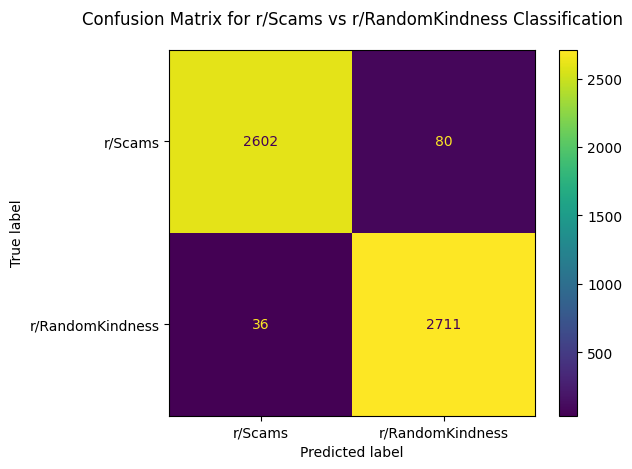

In [30]:
# Generate a confusion matrix
y_pred_test = gs_tfidf_nb.predict(X_test)

# obtain the true and predicted values from test data
tn,fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

# define custom matrix so true positive is top left and true negative is bottom right
custom_cm = np.array([[tp, fn],
                      [fp, tn]])

# Create custom labels for subreddits scraped
custom_display_labels = ['r/Scams', 'r/RandomKindness']

# Plot the confusion matrix with the custom layout
disp = ConfusionMatrixDisplay(confusion_matrix=custom_cm,
                              display_labels=custom_display_labels)

disp.plot()

# Set the title
plt.title("Confusion Matrix for r/Scams vs r/RandomKindness Classification", y = 1.05)
plt.tight_layout()
plt.show()

In [31]:
# Percentage of each element in confusion matrix
total_num = np.sum([tn,fp, fn, tp])

perc_tp = round(tp/total_num * 100, 2) # True positive proportions
perc_tn = round(tn/total_num * 100, 2) # True negative proportions
perc_fp = round(fp/total_num * 100, 2) # False positive proportions
perc_fn = round(fn/total_num * 100, 2) # False negative proportions


# To get a general understanding of what the numbers in the true and predicted values are in the entire test dataset, we can consider using proportions.
print(f'''
    
The percentages of the true and predicted values:
        
    True positives: {perc_tp}%      
    True negatives: {perc_tn}%
    
    False positives: {perc_fp}%
    False negatives: {perc_fn}%

      ''')



    
The percentages of the true and predicted values:
        
    True positives: 47.93%      
    True negatives: 49.94%
    
    False positives: 0.66%
    False negatives: 1.47%

      


### 5.2.4 TF-IDF Multinomial Naive Bayes Accuracy and Recall

- Out of all the scoring metrics, we prioritised accuracy and recall score. 
- It is important for our model to be highly accurate in making the correct classification, so that moderators can use it to reduce the time taken for review of posts with high certainty. 
- Also, we want to pay attention to the sensitivity/ recall rate, and reduce the number of False Negatives, as the consequences of classifying a scam as a random kindness post is much more severe than the reverse.

In [32]:
# obtain cross validation scores based on accuracy and recall
cross_val_final_accuracy = cross_val_score(gs_tfidf_nb,X, y, cv =5, scoring='accuracy', n_jobs =-1).mean()
cross_val_final_recall = cross_val_score(gs_tfidf_nb,X, y, cv =5, scoring='recall', n_jobs=-1).mean()


print(f'Cross validation score with scoring set to \'Accuracy\': {cross_val_final_accuracy:.4f}')
print(f'Cross validation score with scoring set to \'Recall\': {cross_val_final_recall:.4f}')


Cross validation score with scoring set to 'Accuracy': 0.9748
Cross validation score with scoring set to 'Recall': 0.9639


In [33]:
# Compile the final scores into a dataframe

final_model_scores = {
    'Model': ['TF-IDF MultinomialNB','TF-IDF MultinomialNB'],
    'Scorer': ['Accuracy','Recall'],
    'Cross-Validation Score': [cross_val_final_accuracy, cross_val_final_recall]
}

# Convert dictionary to DataFrame
final_model_scores = pd.DataFrame(final_model_scores)

# Display the DataFrame
final_model_scores

,Model,Scorer,Cross-Validation Score
0,TF-IDF MultinomialNB,Accuracy,0.974800
1,TF-IDF MultinomialNB,Recall,0.963865


---

### 5.3 Conclusions
---

#### 5.3.1 Summary

From the cross-validation scores of our baseline models, we identified Multinomial Naive Bayes using TF-IDF as the best scoring model. We performed hypertuning on this model to obtain its best parameters. As a result, we achieved an high accuracy of 0.9748 and sensitivity of 0.9637.


#### 5.3.2 Recommendations
With the success of our classification model, we have several recommendations:

1. The model can be seamlessly integrated into
 existing moderation tools, featuring functionalities that highlight posts classified as either "Potential Scam" or "Potential Random Kindness," aiding moderators in efficiently identifying and addressing potentially harmful content.

2. A feedback loop could be established, allowing moderators to provide feedback on the accuracy of both scam and kindness classifications—whether correct or incorrect—thus enabling continuous improvement of the model's accuracy and sensitivity in identifying both positive and negative content.

3. To adapt to the evolving landscape of scam tactics, the model will undergo continual retraining with new data. This ensures its capability to recognize future scam baits while accurately identifying genuine acts of kindness, thereby maintaining effectiveness in content moderation.

4. Users will be provided with a Transparency Notice, informing them about the utilization of a NLP model to detect scams and random acts of kindness. This transparency fosters trust and empowers users to contribute to a safer and more positive online environment by engaging with the moderation process.